In [76]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
#  Load CSV Files
customers = pd.read_csv("../train/train_customers.csv")
orders = pd.read_csv("../train/orders.csv", low_memory=False)
locations = pd.read_csv("../train/train_locations.csv")
vendors = pd.read_csv("../train/vendors.csv")

In [46]:
orders_merged = orders.merge(customers, on="customer_id", how="left")

In [47]:
orders_merged = orders_merged.merge(vendors, left_on="vendor_id", right_on="id", how="left")

In [48]:
print("Merged Data Shape:", orders_merged.shape)

Merged Data Shape: (135502, 92)


In [49]:

print("\nColumns:\n", orders_merged.columns.tolist())


Columns:
 ['order_id', 'customer_id', 'item_count', 'grand_total', 'payment_mode', 'promo_code', 'vendor_discount_amount', 'promo_code_discount_percentage', 'is_favorite', 'is_rated', 'vendor_rating_x', 'driver_rating', 'deliverydistance', 'preparationtime', 'delivery_time', 'order_accepted_time', 'driver_accepted_time', 'ready_for_pickup_time', 'picked_up_time', 'delivered_time', 'delivery_date', 'vendor_id', 'created_at_x', 'location_number', 'LOCATION_TYPE', 'CID X LOC_NUM X VENDOR', 'gender', 'dob', 'status_x', 'verified_x', 'language_x', 'created_at_y', 'updated_at_x', 'id', 'authentication_id', 'latitude', 'longitude', 'vendor_category_en', 'vendor_category_id', 'delivery_charge', 'serving_distance', 'is_open', 'OpeningTime', 'OpeningTime2', 'prepration_time', 'commission', 'is_haked_delivering', 'discount_percentage', 'status_y', 'verified_y', 'rank', 'language_y', 'vendor_rating_y', 'sunday_from_time1', 'sunday_to_time1', 'sunday_from_time2', 'sunday_to_time2', 'monday_from_ti

In [50]:
print("\nMissing Values (Top 10):\n", orders_merged.isna().sum().sort_values(ascending=False).head(10))


Missing Values (Top 10):
 promo_code              131177
delivery_time           130370
dob                     123633
delivery_date            99958
vendor_rating_x          90233
driver_accepted_time     88925
tuesday_from_time2       78632
tuesday_to_time2         78632
sunday_from_time2        78025
thursday_from_time2      78025
dtype: int64


In [51]:
# define Features & Target
features = [
    'item_count', 'grand_total', 'vendor_rating_x', 'driver_rating',
    'deliverydistance', 'preparationtime'
]
target = 'vendor_id'

In [52]:
orders_merged = orders_merged.dropna(subset=features + [target])


In [53]:
X = orders_merged[features]
y = orders_merged[target]

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [66]:
y_pred = model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           4       0.21      0.23      0.22        69
          13       0.38      0.31      0.34        32
          20       0.32      0.25      0.28        59
          23       0.07      0.06      0.07        34
          28       0.25      0.21      0.23        95
          33       0.22      0.20      0.21        98
          43       0.29      0.31      0.30        45
          44       0.31      0.32      0.31       111
          55       0.27      0.32      0.29        50
          66       0.00      0.00      0.00         1
          67       0.25      0.17      0.20        47
          75       0.36      0.21      0.26        24
          76       0.42      0.33      0.37        45
          79       0.39      0.49      0.43       371
          81       0.43      0.33      0.38         9
          82       0.17      0.12      0.14        59
          83       0.75      0.23      0.35        13
  

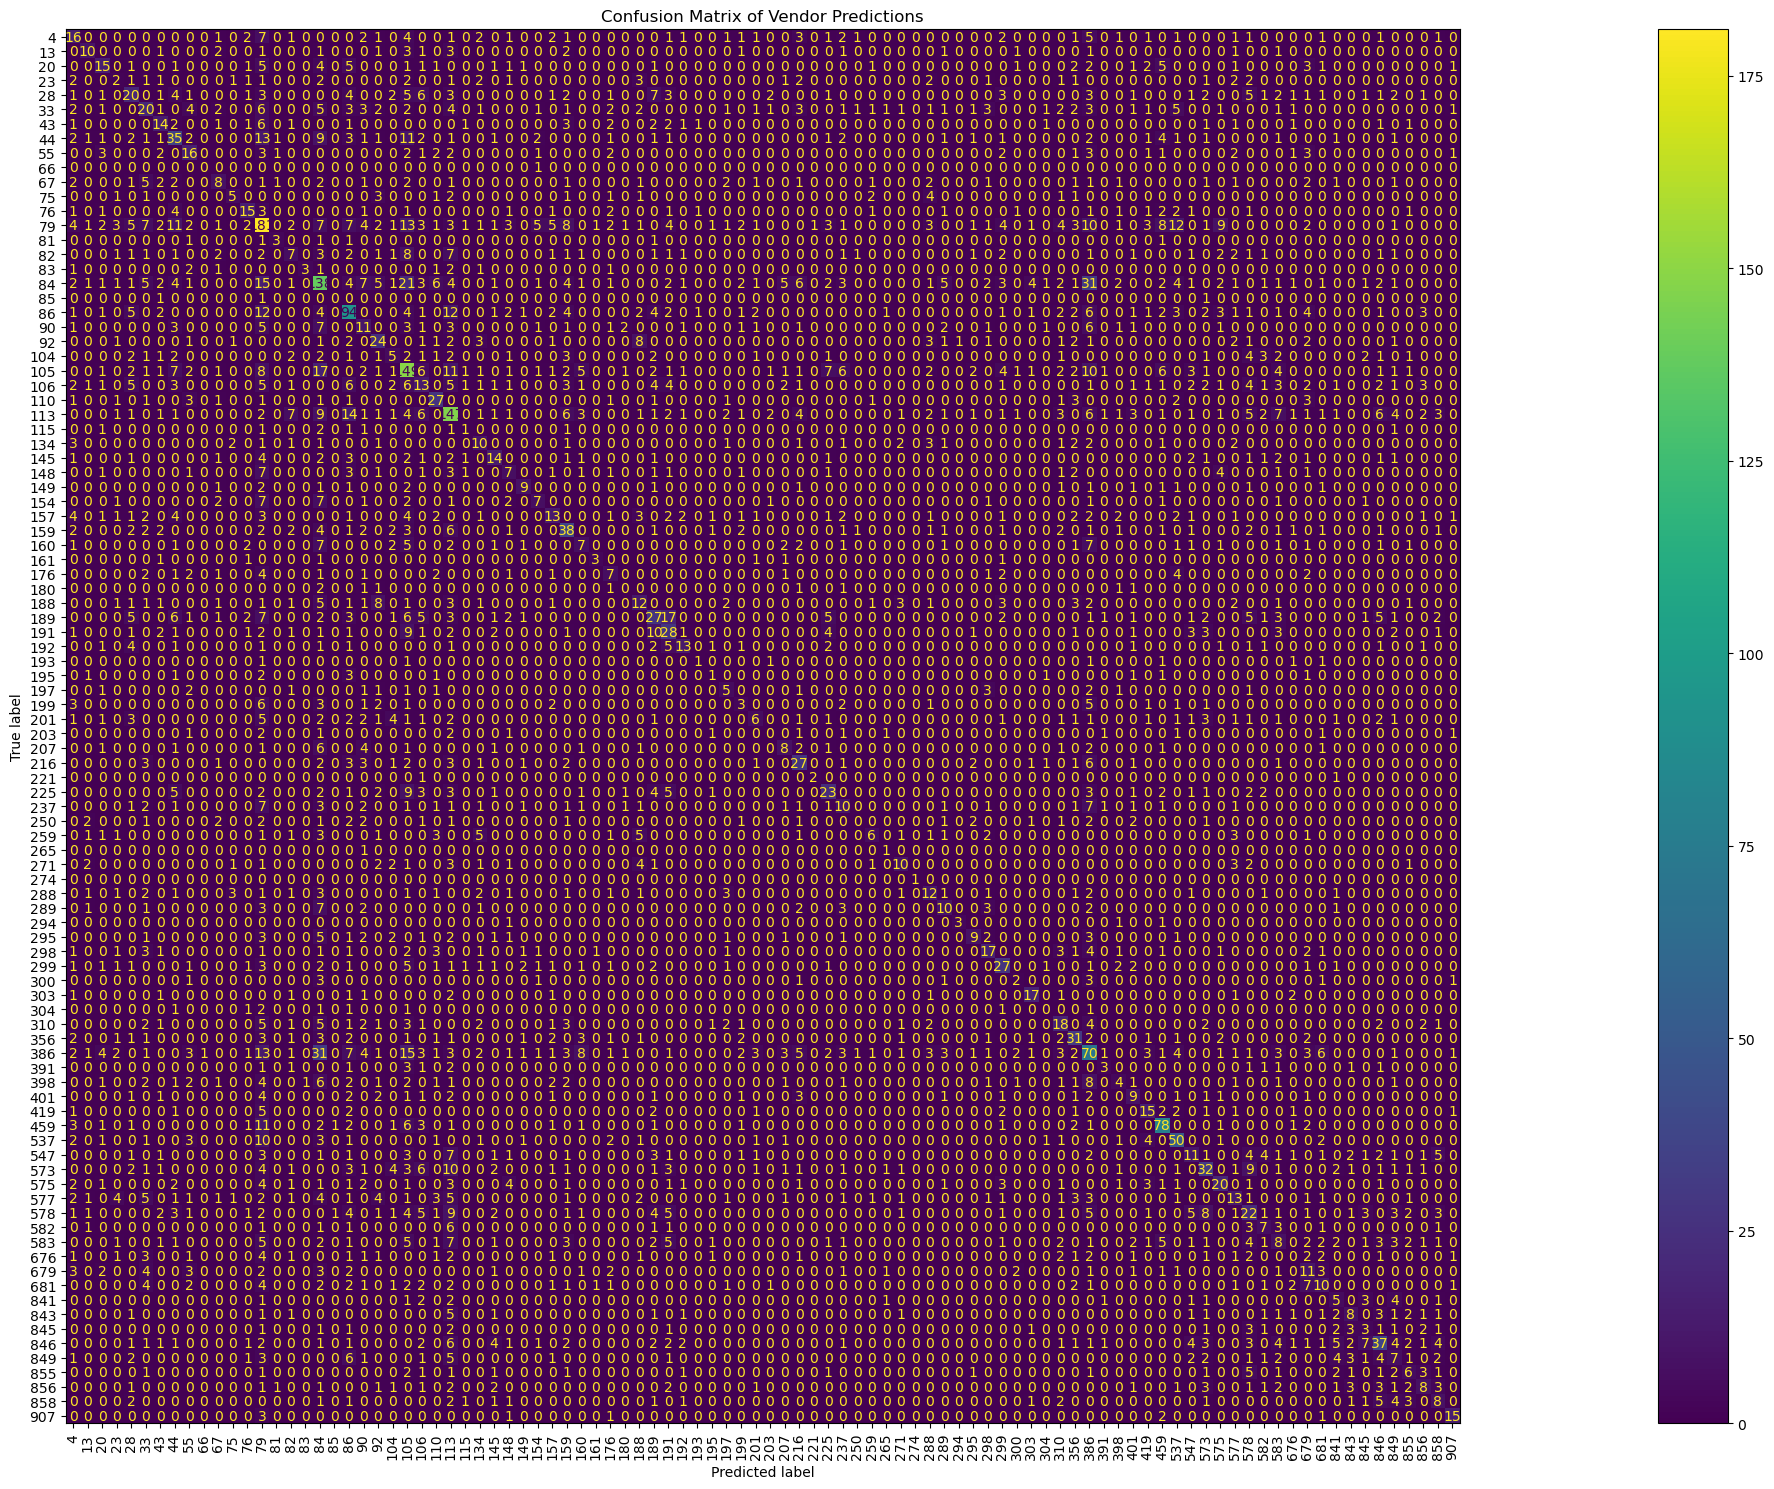

In [100]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
fig, ax = plt.subplots(figsize=(40, 15))
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
cmd.plot(ax=ax, cmap='viridis', xticks_rotation=90)
plt.title("Confusion Matrix of Vendor Predictions")
plt.tight_layout()
plt.show()

In [67]:
test_customers = pd.read_csv("../test/test_customers.csv")
test_locations = pd.read_csv("../test/test_locations.csv")


In [68]:
test_df = test_customers.merge(test_locations, on="customer_id", how="left")

In [78]:
test_df = test_df.merge(customers.drop_duplicates('customer_id'), on='customer_id', how='left')
test_df = test_df.merge(locations.drop_duplicates(['customer_id', 'location_number']), on=['customer_id', 'location_number'], how='left')


In [81]:
features = [
    'item_count', 'grand_total', 'vendor_rating', 'driver_rating',
    'deliverydistance', 'preparationtime'
]


In [89]:
# Get most frequent vendor per (cluster/zone)
popular_vendors = orders_merged.groupby('location_number')['vendor_id'].agg(lambda x: x.value_counts().index[0]).reset_index()


In [90]:
print(test_locations.columns)
print(popular_vendors.columns)

Index(['customer_id', 'location_number', 'location_type', 'latitude',
       'longitude'],
      dtype='object')
Index(['location_number', 'vendor_id'], dtype='object')


In [91]:
#  Merge with test locations
submission = test_locations.merge(popular_vendors, on='location_number', how='left')

In [92]:
#  Attach customer_id from test_customers
submission = submission.merge(test_customers[['customer_id']], on='customer_id', how='left')

In [95]:
# Save
submission[['customer_id', 'location_number', 'vendor_id']].to_csv("../submission/submission.csv", index=False)

In [96]:
import joblib
joblib.dump(model, "../models/vendor_recommendation_model.pkl") # Save the trained model

['../models/vendor_recommendation_model.pkl']